<a href="https://colab.research.google.com/github/VintiShukla/Ridesharing-surge-prediction/blob/master/ride_surge_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NCR Ride Bookings Preprocessing

In [ ]:
pip install mlflow optuna joblib lightgbm shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import mlflow
import mlflow.lightgbm
import mlflow.xgboost
import optuna
import joblib
import logging
import shap

In [ ]:
# ---------------------------- CONFIG ----------------------------------
CONFIG = {
    "ride_data_path": "ncr_ride_bookings.csv",
    "weather_data_path": "kaggel_weather_2013_to_2024.csv",
    "surge_threshold_quantile": 0.75,
    "random_state": 42,
    "test_size": 0.2
}

logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
logger = logging.getLogger(__name__)

In [ ]:
# ---------------------------- DATA PREPROCESSING -----------------------
def preprocess_ride_data(path):
    logger.info("Loading and preprocessing ride data...")
    df = pd.read_csv(path)
    df.drop(["Booking ID", "Customer ID"], axis=1, inplace=True)

    df['Original_Date'] = pd.to_datetime(df['Date'])
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['Hour'] = df['Datetime'].dt.hour
    df['Day'] = df['Datetime'].dt.day
    df['Month'] = df['Datetime'].dt.month
    df['Weekday'] = df['Datetime'].dt.dayofweek
    df['Is_Weekend'] = df['Weekday'].isin([5, 6]).astype(int)
    df.drop(['Date', 'Time', 'Datetime'], axis=1, inplace=True)

    for col in ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance']:
        df[col] = df.groupby('Vehicle Type')[col].transform(lambda x: x.fillna(x.median()))
    for col in ['Driver Ratings', 'Customer Rating']:
        df[col] = df.groupby('Vehicle Type')[col].transform(lambda x: x.fillna(x.mean()))

    df['Cancelled Rides by Customer'] = df['Cancelled Rides by Customer'].fillna(0)
    df['Cancelled Rides by Driver'] = df['Cancelled Rides by Driver'].fillna(0)
    df['Incomplete Rides'] = df['Incomplete Rides'].fillna(0)
    df['Reason for cancelling by Customer'] = df['Reason for cancelling by Customer'].fillna("No Cancellation")
    df['Driver Cancellation Reason'] = df['Driver Cancellation Reason'].fillna("No Cancellation")
    df['Incomplete Rides Reason'] = df['Incomplete Rides Reason'].fillna("Completed")
    df['Payment Method'] = df['Payment Method'].fillna("Unknown")

    fare_threshold = df['Booking Value'].quantile(CONFIG["surge_threshold_quantile"])
    df['Is_Surge'] = (df['Booking Value'] > fare_threshold).astype(int)

    le = LabelEncoder()
    string_cat_cols = ['Vehicle Type', 'Pickup Location', 'Drop Location', 'Payment Method']
    for col in string_cat_cols:
        df[col + '_Encoded'] = le.fit_transform(df[col])
        df.drop(col, axis=1, inplace=True)

    other_cat_cols = ['Reason for cancelling by Customer', 'Driver Cancellation Reason',
                      'Incomplete Rides Reason', 'Booking Status', 'Is_Surge']
    for col in other_cat_cols:
        df[col + '_Encoded'] = le.fit_transform(df[col].astype(str))
        df.drop(col, axis=1, inplace=True)

    logger.info(f"Ride data preprocessing complete. Shape: {df.shape}")
    return df

In [ ]:
def preprocess_weather_data(path):
    logger.info("Loading and cleaning weather data...")
    weather_df = pd.read_csv(path)
    if 'Unnamed: 0' in weather_df.columns:
        weather_df.drop(columns=['Unnamed: 0'], inplace=True)
    weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
    weather_df.fillna(method='ffill', inplace=True)
    weather_df.columns = weather_df.columns.str.strip().str.lower().str.replace(' ', '_')
    logger.info(f"Weather data cleaned. Shape: {weather_df.shape}")
    return weather_df

In [ ]:
def merge_and_scale(df, weather_df):
    logger.info("Merging ride and weather data...")
    weather_2024 = weather_df[weather_df['year'] == 2024].copy()
    merged_df = pd.merge(df, weather_2024, left_on='Original_Date', right_on='date', how='left')
    merged_df.drop(columns=['date'], inplace=True)

    weather_columns = [c for c in weather_df.columns if c not in ['date']]
    merged_df.sort_values(by='Original_Date', inplace=True)
    merged_df[weather_columns] = merged_df[weather_columns].ffill()

    num_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    exclude_from_scaling = ['year', 'month_y', 'day_y']
    num_cols = [col for col in num_cols if col not in exclude_from_scaling]

    scaler = StandardScaler()
    merged_df[num_cols] = scaler.fit_transform(merged_df[num_cols])

    joblib.dump(scaler, "scaler.pkl")
    logger.info("Scaling complete and scaler saved as scaler.pkl")

    merged_df.to_csv('preprocessed_ride_data.csv', index=False)
    logger.info(f"Merged preprocessed data saved. Shape: {merged_df.shape}")
    return merged_df


In [ ]:
# ---------------------------- MODEL TRAINING ---------------------------
def train_lightgbm(df):
    logger.info("Training LightGBM model...")

    X = df.drop(['Booking Value', 'Original_Date'], axis=1)
    y = df['Booking Value']

    # Handle any object columns that might have come from weather (like 'conditions')
    object_cols = X.select_dtypes(include=['object']).columns
    if len(object_cols) > 0:
        logger.warning(f"Encoding object columns: {list(object_cols)}")
        for col in object_cols:
            X[col] = X[col].astype('category').cat.codes

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=CONFIG["test_size"], random_state=CONFIG["random_state"]
    )

    def objective(trial):
        params = {
            'objective': 'regression_l1',
            'metric': 'rmse',
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'random_state': CONFIG["random_state"],
            'n_jobs': -1,
        }
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)],
                  callbacks=[lgb.early_stopping(100, verbose=False)])
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        return rmse

    # --------------------- Hyperparameter Tuning ---------------------
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    best_params = study.best_params

    # --------------------- Model Training ---------------------
    mlflow.set_experiment("Ride Surge Prediction")
    with mlflow.start_run(run_name="Tuned LightGBM"):
        mlflow.log_params(best_params)

        model = lgb.LGBMRegressor(**best_params, random_state=CONFIG["random_state"])
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mlflow.log_metric("rmse", rmse)
        mlflow.lightgbm.log_model(model, "lgbm-ride-surge-model")

        # --------------------- Explainable AI (SHAP) ---------------------
        logger.info("Generating SHAP explainability plots...")
        import shap
        import matplotlib.pyplot as plt

        # Create SHAP explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # Global Feature Importance Plot
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
        plt.title("Feature Importance (SHAP)")
        plt.tight_layout()
        plt.savefig("shap_summary_bar.png", dpi=200)
        plt.close()

        # Detailed Beeswarm Plot
        shap.summary_plot(shap_values, X_test, show=False)
        plt.title("SHAP Feature Impact (Beeswarm)")
        plt.tight_layout()
        plt.savefig("shap_summary_beeswarm.png", dpi=200)
        plt.close()

        # Log SHAP plots in MLflow
        mlflow.log_artifact("shap_summary_bar.png")
        mlflow.log_artifact("shap_summary_beeswarm.png")

        logger.info("SHAP explainability plots generated and logged to MLflow.")

    # --------------------- Save Model ---------------------
    joblib.dump(model, "lgbm_model.pkl")
    logger.info(f"LightGBM training complete. RMSE: {rmse:.3f}. Model saved as lgbm_model.pkl")

    return model, rmse

In [ ]:
def train_xgboost(df):
    logger.info("Training XGBoost model...")

    X = df.drop(['Booking Value', 'Original_Date'], axis=1)
    y = df['Booking Value']

    # Handle any object columns that might have come from weather (like 'conditions')
    object_cols = X.select_dtypes(include=['object']).columns
    if len(object_cols) > 0:
        logger.warning(f"Encoding object columns: {list(object_cols)}")
        for col in object_cols:
            X[col] = X[col].astype('category').cat.codes

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=CONFIG["test_size"], random_state=CONFIG["random_state"]
    )

    # --------------------- Hyperparameter Tuning ---------------------
    def objective_xgb(trial):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'n_estimators': trial.suggest_int('n_estimators', 500, 2500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 0.5),
            'random_state': CONFIG["random_state"],
            'n_jobs': -1,
            'tree_method': 'hist',
            'enable_categorical': True
        }
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        return rmse

    study_xgb = optuna.create_study(direction='minimize')
    study_xgb.optimize(objective_xgb, n_trials=50)
    best_params = study_xgb.best_params

    # --------------------- Model Training ---------------------
    mlflow.set_experiment("Ride Surge Prediction")
    with mlflow.start_run(run_name="Tuned XGBoost"):
        mlflow.log_params(best_params)

        model = xgb.XGBRegressor(**best_params, random_state=CONFIG["random_state"],
                                 tree_method='hist', enable_categorical=True)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mlflow.log_metric("rmse", rmse)
        mlflow.xgboost.log_model(model, "xgb-ride-surge-model")

        # --------------------- Explainable AI (SHAP) ---------------------
        logger.info("Generating SHAP explainability plots for XGBoost...")
        import shap
        import matplotlib.pyplot as plt

        # Create SHAP explainer (TreeExplainer is best for XGBoost)
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test)

        # Global Feature Importance (bar plot)
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
        plt.title("XGBoost Feature Importance (SHAP)")
        plt.tight_layout()
        plt.savefig("xgb_shap_summary_bar.png", dpi=200)
        plt.close()

        # Beeswarm (detailed impact)
        shap.summary_plot(shap_values, X_test, show=False)
        plt.title("XGBoost SHAP Feature Impact (Beeswarm)")
        plt.tight_layout()
        plt.savefig("xgb_shap_summary_beeswarm.png", dpi=200)
        plt.close()

        # Log plots in MLflow
        mlflow.log_artifact("xgb_shap_summary_bar.png")
        mlflow.log_artifact("xgb_shap_summary_beeswarm.png")

        logger.info("SHAP explainability plots for XGBoost saved and logged in MLflow.")

    # --------------------- Save Model ---------------------
    joblib.dump(model, "xgb_model.pkl")
    logger.info(f"XGBoost training complete. RMSE: {rmse:.3f}. Model saved as xgb_model.pkl")

    return model, rmse

In [ ]:
def visualize_model_performance(model, X_test, y_test, model_name="Model"):
    """
    Visualize model predictions vs actual values and print key metrics.
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error, r2_score

    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"\n📊 {model_name} Performance:")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE : {mae:.3f}")
    print(f"R²  : {r2:.3f}")

    # Scatter plot of actual vs predicted
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, preds, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2)
    plt.xlabel("Actual Booking Value")
    plt.ylabel("Predicted Booking Value")
    plt.title(f"{model_name} Predictions vs Actuals")
    plt.tight_layout()
    plt.show()


In [ ]:
# ---------------------------- MAIN ------------------------------------
if __name__ == "__main__":
    ride_df = preprocess_ride_data(CONFIG["ride_data_path"])
    weather_df = preprocess_weather_data(CONFIG["weather_data_path"])
    merged_df = merge_and_scale(ride_df, weather_df)

    lgb_model, lgb_rmse = train_lightgbm(merged_df)
    xgb_model, xgb_rmse = train_xgboost(merged_df)

    logger.info(f"✅ All training complete. LGBM RMSE: {lgb_rmse:.3f}, XGB RMSE: {xgb_rmse:.3f}")


/tmp/ipython-input-4128088631.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_df.fillna(method='ffill', inplace=True)
[I 2025-10-15 18:09:00,406] A new study created in memory with name: no-name-1a076c93-d601-47fe-a94d-0b369749b7de


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-15 18:09:40,630] Trial 0 finished with value: 0.680880084682425 and parameters: {'n_estimators': 1880, 'learning_rate': 0.020890507882679855, 'num_leaves': 290, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.8314035702608608, 'colsample_bytree': 0.9777069736865733}. Best is trial 0 with value: 0.680880084682425.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:09:46,675] Trial 1 finished with value: 0.6784622677108787 and parameters: {'n_estimators': 532, 'learning_rate': 0.16535894993016442, 'num_leaves': 276, 'max_depth': 4, 'min_child_samples': 33, 'subsample': 0.8569027511848326, 'colsample_bytree': 0.774893058176806}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-10-15 18:09:51,159] Trial 2 finished with value: 0.6804724170202326 and parameters: {'n_estimators': 1472, 'learning_rate': 0.09179911158673251, 'num_leaves': 39, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.6562521045194409, 'colsample_bytree': 0.8426688159502055}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:09:56,065] Trial 3 finished with value: 0.6844291096508047 and parameters: {'n_estimators': 1583, 'learning_rate': 0.2999842181939198, 'num_leaves': 279, 'max_depth': 12, 'min_child_samples': 83, 'subsample': 0.8848860570138231, 'colsample_bytree': 0.8317399772046733}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:10:05,059] Trial 4 finished with value: 0.6791336840887698 and parameters: {'n_estimators': 1342, 'learning_rate': 0.12526795495090312, 'num_leaves': 193, 'max_depth': 5, 'min_child_samples': 12, 'subsample': 0.9937656386426713, 'colsample_bytree': 0.7446157776924865}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-15 18:10:08,675] Trial 5 finished with value: 0.6792839469492106 and parameters: {'n_estimators': 1901, 'learning_rate': 0.2527439599899334, 'num_leaves': 255, 'max_depth': 4, 'min_child_samples': 92, 'subsample': 0.9417958098732551, 'colsample_bytree': 0.6147584092426528}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whi

[I 2025-10-15 18:10:12,051] Trial 6 finished with value: 0.6839040004363135 and parameters: {'n_estimators': 561, 'learning_rate': 0.27021778171837263, 'num_leaves': 189, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.8449460107401188, 'colsample_bytree': 0.8259785087615439}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:10:18,866] Trial 7 finished with value: 0.6807521835911307 and parameters: {'n_estimators': 1340, 'learning_rate': 0.06313412395186464, 'num_leaves': 202, 'max_depth': 8, 'min_child_samples': 96, 'subsample': 0.9343458554594722, 'colsample_bytree': 0.9470448348523673}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:10:26,416] Trial 8 finished with value: 0.6823858008370807 and parameters: {'n_estimators': 1755, 'learning_rate': 0.04195647098884855, 'num_leaves': 203, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.8319970808136905, 'colsample_bytree': 0.927521175451089}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:10:31,667] Trial 9 finished with value: 0.6788369064999557 and parameters: {'n_estimators': 873, 'learning_rate': 0.1989549732934274, 'num_leaves': 126, 'max_depth': 4, 'min_child_samples': 65, 'subsample': 0.9773166869961706, 'colsample_bytree': 0.6273627101273567}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:10:35,002] Trial 10 finished with value: 0.6807195019633019 and parameters: {'n_estimators': 974, 'learning_rate': 0.1739785676597594, 'num_leaves': 108, 'max_depth': 3, 'min_child_samples': 40, 'subsample': 0.7283204334545462, 'colsample_bytree': 0.7271618983098563}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:10:39,688] Trial 11 finished with value: 0.6794652022616215 and parameters: {'n_estimators': 529, 'learning_rate': 0.19054483024978894, 'num_leaves': 122, 'max_depth': 6, 'min_child_samples': 62, 'subsample': 0.7202053152624709, 'colsample_bytree': 0.6232757785137802}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:10:43,303] Trial 12 finished with value: 0.6809306100055413 and parameters: {'n_estimators': 892, 'learning_rate': 0.21111170371956384, 'num_leaves': 67, 'max_depth': 3, 'min_child_samples': 52, 'subsample': 0.98306489643999, 'colsample_bytree': 0.6904909476136958}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-15 18:10:46,965] Trial 13 finished with value: 0.6824780835442704 and parameters: {'n_estimators': 848, 'learning_rate': 0.13618560984860756, 'num_leaves': 130, 'max_depth': 10, 'min_child_samples': 37, 'subsample': 0.7665602043313771, 'colsample_bytree': 0.6744915242137254}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:10:51,208] Trial 14 finished with value: 0.6794892204939771 and parameters: {'n_estimators': 738, 'learning_rate': 0.21347076830774148, 'num_leaves': 239, 'max_depth': 5, 'min_child_samples': 68, 'subsample': 0.9035387778808539, 'colsample_bytree': 0.7772187212869246}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:10:55,598] Trial 15 finished with value: 0.6814849260895782 and parameters: {'n_estimators': 1027, 'learning_rate': 0.14984574601352343, 'num_leaves': 150, 'max_depth': 3, 'min_child_samples': 34, 'subsample': 0.8915750784357003, 'colsample_bytree': 0.6673945255448058}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:10:59,920] Trial 16 finished with value: 0.6806219112713608 and parameters: {'n_estimators': 701, 'learning_rate': 0.10794029592329721, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 75, 'subsample': 0.7796055477097679, 'colsample_bytree': 0.8907046550447761}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:11:02,590] Trial 17 finished with value: 0.6787714065246464 and parameters: {'n_estimators': 1074, 'learning_rate': 0.2357952122222865, 'num_leaves': 167, 'max_depth': 4, 'min_child_samples': 46, 'subsample': 0.6130553556021031, 'colsample_bytree': 0.7754148096075552}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:11:14,064] Trial 18 finished with value: 0.6804916369975943 and parameters: {'n_estimators': 1184, 'learning_rate': 0.22935676159887286, 'num_leaves': 241, 'max_depth': 6, 'min_child_samples': 50, 'subsample': 0.6324701476927068, 'colsample_bytree': 0.7801115507644218}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:11:18,586] Trial 19 finished with value: 0.6789444497286212 and parameters: {'n_estimators': 1171, 'learning_rate': 0.24871442505180028, 'num_leaves': 20, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.6892640970743127, 'colsample_bytree': 0.8659531635224778}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start t

[I 2025-10-15 18:11:23,887] Trial 20 finished with value: 0.6791259951614093 and parameters: {'n_estimators': 1081, 'learning_rate': 0.16292299409468214, 'num_leaves': 164, 'max_depth': 6, 'min_child_samples': 45, 'subsample': 0.6022402358031718, 'colsample_bytree': 0.7304074544447068}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:11:27,309] Trial 21 finished with value: 0.6799283293360077 and parameters: {'n_estimators': 708, 'learning_rate': 0.19197231533510883, 'num_leaves': 82, 'max_depth': 4, 'min_child_samples': 60, 'subsample': 0.9486148161571809, 'colsample_bytree': 0.7927548644862541}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:11:32,377] Trial 22 finished with value: 0.6785417456478421 and parameters: {'n_estimators': 847, 'learning_rate': 0.18472997844625122, 'num_leaves': 159, 'max_depth': 4, 'min_child_samples': 27, 'subsample': 0.8636392541740616, 'colsample_bytree': 0.644293357162616}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:11:36,633] Trial 23 finished with value: 0.6790690404070615 and parameters: {'n_estimators': 638, 'learning_rate': 0.23013379442132617, 'num_leaves': 170, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.8528966770249137, 'colsample_bytree': 0.7531432232128294}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:11:41,597] Trial 24 finished with value: 0.6802824831824 and parameters: {'n_estimators': 806, 'learning_rate': 0.17274451245645234, 'num_leaves': 234, 'max_depth': 3, 'min_child_samples': 27, 'subsample': 0.8000944605621879, 'colsample_bytree': 0.6923911178865608}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:11:45,278] Trial 25 finished with value: 0.6785187985806869 and parameters: {'n_estimators': 983, 'learning_rate': 0.2846595621508998, 'num_leaves': 221, 'max_depth': 4, 'min_child_samples': 43, 'subsample': 0.806019808145192, 'colsample_bytree': 0.714813675534341}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:11:47,821] Trial 26 finished with value: 0.679697118733762 and parameters: {'n_estimators': 501, 'learning_rate': 0.29702145394556223, 'num_leaves': 263, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.8035682480851848, 'colsample_bytree': 0.6541520385784703}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-15 18:11:51,942] Trial 27 finished with value: 0.6825557418964986 and parameters: {'n_estimators': 937, 'learning_rate': 0.27319152450319883, 'num_leaves': 219, 'max_depth': 8, 'min_child_samples': 35, 'subsample': 0.8689226003303651, 'colsample_bytree': 0.709468752721776}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:11:57,871] Trial 28 finished with value: 0.6841186902741802 and parameters: {'n_estimators': 747, 'learning_rate': 0.10536245119663495, 'num_leaves': 294, 'max_depth': 10, 'min_child_samples': 42, 'subsample': 0.7447626370363366, 'colsample_bytree': 0.6410817512551875}. Best is trial 1 with value: 0.6784622677108787.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:12:04,670] Trial 29 finished with value: 0.6781832045854569 and parameters: {'n_estimators': 650, 'learning_rate': 0.07590612239091825, 'num_leaves': 275, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.8162667402637607, 'colsample_bytree': 0.6963966983850924}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:12:14,984] Trial 30 finished with value: 0.678784448534508 and parameters: {'n_estimators': 601, 'learning_rate': 0.0247722148263187, 'num_leaves': 280, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.814900474522382, 'colsample_bytree': 0.755599377818025}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-10-15 18:12:26,196] Trial 31 finished with value: 0.6784477471661984 and parameters: {'n_estimators': 636, 'learning_rate': 0.08248688138283693, 'num_leaves': 299, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.8233759074380169, 'colsample_bytree': 0.6030602799354667}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:12:31,106] Trial 32 finished with value: 0.6785978147727648 and parameters: {'n_estimators': 677, 'learning_rate': 0.08286688295342273, 'num_leaves': 299, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.8216926512460232, 'colsample_bytree': 0.711645398853494}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:12:39,548] Trial 33 finished with value: 0.6794054179349771 and parameters: {'n_estimators': 614, 'learning_rate': 0.06601053733102964, 'num_leaves': 269, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.7826461399539056, 'colsample_bytree': 0.6791731822223657}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:12:45,114] Trial 34 finished with value: 0.6788562251962469 and parameters: {'n_estimators': 505, 'learning_rate': 0.05121031015683066, 'num_leaves': 276, 'max_depth': 5, 'min_child_samples': 20, 'subsample': 0.7646670777674404, 'colsample_bytree': 0.8151185470671661}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:12:57,640] Trial 35 finished with value: 0.6791412462304908 and parameters: {'n_estimators': 793, 'learning_rate': 0.01652974849445761, 'num_leaves': 255, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.9125298668011822, 'colsample_bytree': 0.608965694489739}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:13:02,575] Trial 36 finished with value: 0.6803401079320338 and parameters: {'n_estimators': 1589, 'learning_rate': 0.08786441945901116, 'num_leaves': 223, 'max_depth': 7, 'min_child_samples': 17, 'subsample': 0.8422691833854444, 'colsample_bytree': 0.8585419612689874}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:13:06,374] Trial 37 finished with value: 0.6790998513748472 and parameters: {'n_estimators': 598, 'learning_rate': 0.12266079151603616, 'num_leaves': 287, 'max_depth': 5, 'min_child_samples': 33, 'subsample': 0.8776863937505915, 'colsample_bytree': 0.7070654877395967}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the tr

[I 2025-10-15 18:13:13,346] Trial 38 finished with value: 0.6790107004081246 and parameters: {'n_estimators': 1333, 'learning_rate': 0.07369569903415395, 'num_leaves': 249, 'max_depth': 3, 'min_child_samples': 57, 'subsample': 0.8304642590184647, 'colsample_bytree': 0.8087101717492271}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:13:22,607] Trial 39 finished with value: 0.6794216358673082 and parameters: {'n_estimators': 1467, 'learning_rate': 0.03715127003034378, 'num_leaves': 218, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.689313758503981, 'colsample_bytree': 0.7373361251195851}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:13:28,604] Trial 40 finished with value: 0.6805024318450892 and parameters: {'n_estimators': 971, 'learning_rate': 0.10301472060596822, 'num_leaves': 269, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.78572217382876, 'colsample_bytree': 0.9943569552100767}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:13:35,521] Trial 41 finished with value: 0.6783274248224348 and parameters: {'n_estimators': 790, 'learning_rate': 0.1328693358172632, 'num_leaves': 194, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.8612848242298781, 'colsample_bytree': 0.6431675138922843}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:13:40,550] Trial 42 finished with value: 0.6793909800678765 and parameters: {'n_estimators': 775, 'learning_rate': 0.14102721936537008, 'num_leaves': 183, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.9198545299709111, 'colsample_bytree': 0.6043949197188625}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:13:48,012] Trial 43 finished with value: 0.6784447514331285 and parameters: {'n_estimators': 624, 'learning_rate': 0.1226135782835665, 'num_leaves': 202, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.8536792854260982, 'colsample_bytree': 0.6601494147864626}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:13:55,419] Trial 44 finished with value: 0.6792050121505259 and parameters: {'n_estimators': 661, 'learning_rate': 0.1228123111730198, 'num_leaves': 202, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.8889472833366903, 'colsample_bytree': 0.6362018811474137}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:14:03,918] Trial 45 finished with value: 0.6797608313437178 and parameters: {'n_estimators': 600, 'learning_rate': 0.13386552143764152, 'num_leaves': 300, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.8490498631512738, 'colsample_bytree': 0.6512254886355118}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:14:07,718] Trial 46 finished with value: 0.6784497877863311 and parameters: {'n_estimators': 524, 'learning_rate': 0.11478953223297111, 'num_leaves': 284, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.8684206503318248, 'colsample_bytree': 0.6002559584368765}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:14:16,605] Trial 47 finished with value: 0.6784008877644129 and parameters: {'n_estimators': 1997, 'learning_rate': 0.09646812844034375, 'num_leaves': 284, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.8312728008775521, 'colsample_bytree': 0.6238286691559576}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-10-15 18:14:27,453] Trial 48 finished with value: 0.6784279664654946 and parameters: {'n_estimators': 1835, 'learning_rate': 0.05663920642257794, 'num_leaves': 139, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.8306428061576041, 'colsample_bytree': 0.6229126900732281}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.194694


[I 2025-10-15 18:14:33,554] Trial 49 finished with value: 0.682304866349094 and parameters: {'n_estimators': 1951, 'learning_rate': 0.05591461446986796, 'num_leaves': 141, 'max_depth': 11, 'min_child_samples': 9, 'subsample': 0.8401520939707872, 'colsample_bytree': 0.6647300716458547}. Best is trial 29 with value: 0.6781832045854569.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5039
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 47
[LightGBM] [Info] Start training from score -0.001115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

2025/10/15 18:14:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/15 18:14:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-10-15 18:15:59,128] A new study created in memory with name: no-name-0d2d3a46-713b-43b7-9cdd-ee490c804f09
[I 2025-10-15 18:16:31,033] Trial 0 finished with value: 0.6661248331645702 and parameters: {'n_estimators': 2497, 'learning_rate': 0.08647821783093848, 'max_depth': 4, 'subsample': 0.9938958480047091, 'colsample_bytree': 0.6146609023051715, 'min_child_weight': 7, 'gamma': 0.09856169857415337}. Best is trial 0 with value: 0.6661248331645702.
[I 2025-10-15 18:17:02,172] Trial 1 finished with value: 0.6914305421172265 and parameters: {'n_estimators': 1731, 'learning_rate': 0.09569243042147575, 'max_depth': 9, 'subsample': 0.7921170237279782, 'colsample_bytree': 0.504691167590363


📊 LightGBM Performance:
RMSE: 0.665
MAE : 0.355
R²  : 0.569


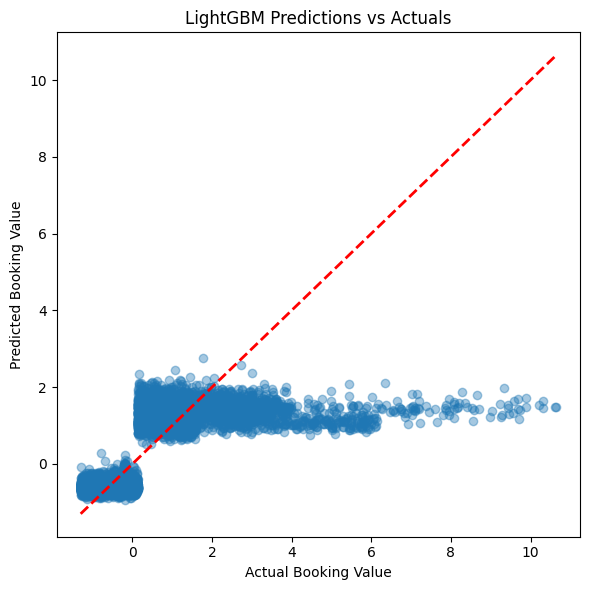


📊 XGBoost Performance:
RMSE: 0.658
MAE : 0.349
R²  : 0.578


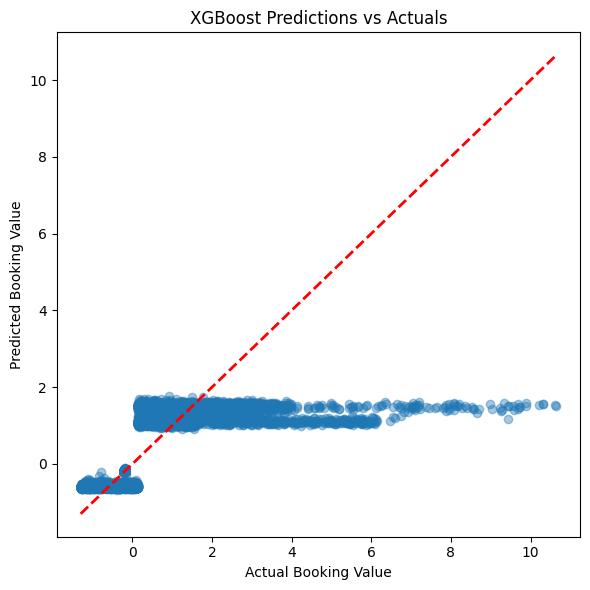

In [ ]:
from sklearn.model_selection import train_test_split

X = merged_df.drop(['Booking Value', 'Original_Date'], axis=1)
y = merged_df['Booking Value']

# Encode any object columns if needed
object_cols = X.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    for col in object_cols:
        X[col] = X[col].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
visualize_model_performance(lgb_model, X_test, y_test, "LightGBM")
visualize_model_performance(xgb_model, X_test, y_test, "XGBoost")

In [ ]:
!zip -r ride_surge_project.zip /content
from google.colab import files
files.download("ride_surge_project.zip")